# Regression and Other Stories: Gay

In [1]:
import arviz as az
from bambi import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

In [3]:
def percent_total(df):
    return df / df.groupby(level=0).sum()

age_cutpoints = np.concatenate(([0], np.arange(29, 89, 10), [100]))

df = (
    data
    .assign(
        response = lambda df: df['gayFavorStateMarriage'], 
        age = lambda df: df['age'].clip(18, 91)
        )
    .groupby(['age', 'response']).size()
    .rename('support')
    .pipe(percent_total)
    .reset_index()
    .query("response == 'Yes'")
    .assign(age_discrete = lambda df: pd.cut(df['age'], age_cutpoints).astype(str))
)
df.head()

,age,response,support,age_discrete
1,18.0,Yes,0.486056,"(0, 29]"
3,19.0,Yes,0.500000,"(0, 29]"
5,20.0,Yes,0.472393,"(0, 29]"
7,21.0,Yes,0.463303,"(0, 29]"
9,22.0,Yes,0.453271,"(0, 29]"


In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Gay/data/naes04.csv")
data.head()

,Unnamed: 0,age,gender,race,gayFavorFederalMarriage,gayFavorStateMarriage,gayKnowSomeone
0,1,70.0,Female,Hispanic,No,NaN,NaN
1,2,54.0,Female,White,No,NaN,NaN
2,3,74.0,Male,White,No,NaN,NaN
3,4,73.0,Female,Other,Yes,No,No
4,5,48.0,Female,White,No,Yes,Yes


In [4]:
model = Model(df)
fit_linear = model.fit('support ~ age', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [support_sd, age, Intercept]
INFO:pymc3:NUTS: [support_sd, age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The acceptance probability does not match the target. It is 0.9290356528897706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986042337763115, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/farhanreynaldo/miniconda3/envs/bambi/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [5]:
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }

linear_coefs = az.summary(fit_linear, stat_funcs=func_dict, extend=False)
linear_coefs

,Median,MAD_SD
Intercept[0],0.554,0.007
age[0],-0.005,0.000
support_sd,0.034,0.002


In [6]:
model = Model(df)
fit_binned = model.fit('support ~ C(age_discrete)', samples=1000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [support_sd, C(age_discrete), Intercept]
INFO:pymc3:NUTS: [support_sd, C(age_discrete), Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
/Users/farhanreynaldo/miniconda3/envs/bambi/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [7]:
binned_coefs = az.summary(fit_binned, stat_funcs=func_dict, extend=False)
binned_coefs

,Median,MAD_SD
Intercept[0],0.453,0.006
C(age_discrete)[0],-0.087,0.009
C(age_discrete)[1],-0.128,0.009
C(age_discrete)[2],-0.132,0.009
C(age_discrete)[3],-0.235,0.009
C(age_discrete)[4],-0.263,0.009
C(age_discrete)[5],-0.304,0.008
support_sd,0.031,0.002


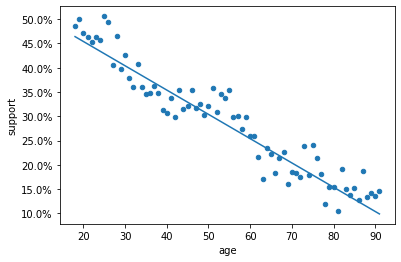

In [9]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots()

a_hat = linear_coefs.loc["Intercept[0]", "Median"]
b_hat = linear_coefs.loc["age[0]", "Median"]

# Generate x range
age_domain = np.linspace(df["age"].min(), df["age"].max(), 100)

# Plot Line
ax.plot(age_domain, a_hat + b_hat * age_domain)

# Add scatter plot
df.plot(kind="scatter", x="age", y="support", ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));

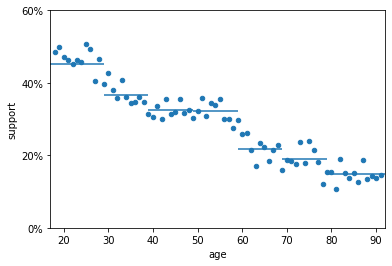

In [15]:
fig, ax = plt.subplots()

# Add scatter plot
df.plot(kind="scatter", x="age", y="support", ax=ax)

# Add horizontal line for age bins
intercept = binned_coefs.iloc[0, 0]
for i in range(len(age_cutpoints)-1):
    y = intercept if i == 0 else intercept + binned_coefs.iloc[i, 0]
    ax.hlines(y=y, xmin=age_cutpoints[i], xmax=age_cutpoints[i+1])

ax.set_xlim(17, 92)
ax.yaxis.set_ticks(np.arange(0, .7, .2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1));